# 填充三角形

## 老式做法 ：扫描线算法
- 根据顶点的y坐标来对顶点进行排序
- 同时光栅化三角形的左边和右边
- 在左边和右边之间画水平线

### 对三角形顶点排序

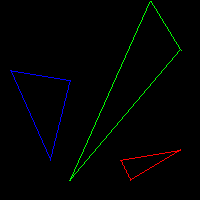

In [23]:
import buffer

#定义一些颜色
red = (255, 0, 0)
green = (0, 255, 0)
blue = (0, 0, 255)

#定义一个三角形类
class Triangle:
    def __init__(self, v0, v1, v2) -> None:
        self.v0 = v0
        self.v1 = v1
        self.v2 = v2

t0 = Triangle((10, 70), (50, 160), (70, 80))
t1 = Triangle((180, 50), (150, 1), (70, 180))
t2 = Triangle((180, 150), (120, 160), (130, 180))

#渲染三角形外框
def r_triange1(triangle, fb, color):
    fb.draw_line(triangle.v0, triangle.v1, color)
    fb.draw_line(triangle.v1, triangle.v2, color)
    fb.draw_line(triangle.v2, triangle.v0, color)

fb = buffer.FrameBuffer(200, 200)
r_triange1(t0, fb, blue)
r_triange1(t1, fb, green)
r_triange1(t2, fb, red)

fb.display()

接下来我们对三角形的顶点进行排序。将其分为左边界和右边界，我们用蓝色来表示有两段的边界，用绿色来表示只有一段的边界。

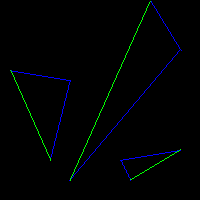

In [24]:
def r_triange2(triangle, fb):
    if(triangle.v0[1] > triangle.v1[1]):
        x = triangle.v0
        triangle.v0 = triangle.v1
        triangle.v1 = x
    if(triangle.v1[1] > triangle.v2[1]):
        x = triangle.v2
        triangle.v2 = triangle.v1
        triangle.v1 = x
    if(triangle.v0[1] > triangle.v1[1]):
        x = triangle.v0
        triangle.v0 = triangle.v1
        triangle.v1 = x
    fb.draw_line(triangle.v0, triangle.v1, blue)
    fb.draw_line(triangle.v1, triangle.v2, blue)
    fb.draw_line(triangle.v2, triangle.v0, green)

fb.clear()
r_triange2(t0, fb)
r_triange2(t1, fb)
r_triange2(t2, fb)

fb.display()

### 同时光栅化三角形的左边和右边
我们先把三角形从上到下分为两个部分分别渲染,分界点就是中间的那个顶点。

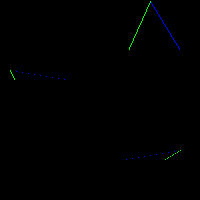

In [25]:
def r_triange3_up(triangle, fb):
    #假设三角形已经经过排序了
    height1 = triangle.v1[1] - triangle.v0[1]
    height2 = triangle.v2[1] - triangle.v0[1]
    for i in range(round(triangle.v0[1]), round(triangle.v1[1])):
        alpha = (i - triangle.v0[1]) / height1 
        beta = (i - triangle.v0[1]) / height2
        x1 = triangle.v0[0] + alpha * (triangle.v1[0] - triangle.v0[0]) 
        x2 = triangle.v0[0] + beta * (triangle.v2[0] - triangle.v0[0])
        fb.draw_point((x1, i), blue)
        fb.draw_point((x2, i), green)

fb.clear()
r_triange3_up(t0, fb) 
r_triange3_up(t1, fb) 
r_triange3_up(t2, fb) 
fb.display()

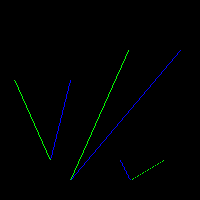

In [26]:
def r_triange3_down(triangle, fb):
    #假设三角形已经经过排序了
    height1 = triangle.v2[1] - triangle.v1[1]
    height2 = triangle.v2[1] - triangle.v0[1]
    for i in range(round(triangle.v1[1]), round(triangle.v2[1])):
        alpha = (i - triangle.v1[1]) / height1 
        beta = (i - triangle.v0[1]) / height2
        x1 = triangle.v1[0] + alpha * (triangle.v2[0] - triangle.v1[0]) 
        x2 = triangle.v0[0] + beta * (triangle.v2[0] - triangle.v0[0])
        fb.draw_point((x1, i), blue)
        fb.draw_point((x2, i), green)

fb.clear()
r_triange3_down(t0, fb) 
r_triange3_down(t1, fb) 
r_triange3_down(t2, fb) 
fb.display()

### 在渲染的过程中在左边和右边之间加水平线

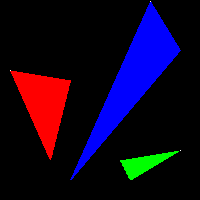

In [27]:
def r_triange(triangle, fb, color):
    #渲染上半部分
    x0, y0 = triangle.v0
    x1, y1 = triangle.v1
    x2, y2 = triangle.v2

    height = y2 - y0
    height1 = y1 - y0
    height2 = y2 - y1
    for i in range(y0, y1):
        alpha = (i - y0) / height1
        beta = (i - y0) / height
        sx = x0 + alpha * (x1 - x0)
        lx = x0 + beta * (x2 - x0)
        fb.draw_line((sx, i), (lx, i), color)
    for i in range(y1, y2):
        alpha = (i - y1) / height2
        beta = (i - y0) / height
        sx = x1 + alpha * (x2 - x1)
        lx = x0 + beta * (x2 - x0)
        fb.draw_line((sx, i), (lx, i), color)

fb.clear()
r_triange(t0, fb, red)
r_triange(t1, fb, blue)
r_triange(t2, fb, green)
fb.display()

## 新做法，判断点是否在三角形内
老式做法对传统的串行渲染来说已经足够快了，但是现代GPU流水线中，我们大量使用SIMD指令来实现并行，这就导致原来的算法虽然计算量比较小，但是无法并行。在现代cpu中我们使用向量的方法，对每一个像素用相同的程序进行判断。这样在宏观上我们只需要一个指令的时间就可以完成三角形的渲染。

具体来说，我们有两种比较好的方法，第一种就是通过向量点乘，另一种就是计算重心坐标。现在最常用的还是重心坐标，因为它不仅仅在这上面可以用得到，在后面对顶点的性质进行插值的时候，重心坐标也会非常的有用。

### 点乘算法
首先我们来进行向量的点乘算法。我们首先要计算垂直于每条边的向量。

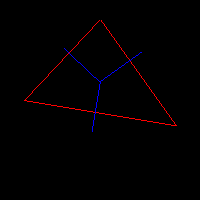

In [28]:
from geometry import Vec2, Vec3
t = Triangle((100, 20), (25, 100), (175, 125))

fb.clear()
r_triange1(t, fb, red)

v0 = Vec2(t.v0[0] - t.v1[0], t.v0[1] - t.v1[1])
v1 = Vec2(t.v1[0] - t.v2[0], t.v1[1] - t.v2[1])
v2 = Vec2(t.v2[0] - t.v0[0], t.v2[1] - t.v0[1])

center = Vec2((t.v0[0] + t.v1[0] + t.v2[0]) / 3, (t.v0[1] + t.v1[1] + t.v2[1]) / 3)

v0 = v0.rotate(-90).norm() * 50 + center
v1 = v1.rotate(-90).norm() * 50 + center
v2 = v2.rotate(-90).norm() * 50 + center

fb.draw_line(center.to_tuple(), v0.to_tuple(), blue)
fb.draw_line(center.to_tuple(), v1.to_tuple(), blue)
fb.draw_line(center.to_tuple(), v2.to_tuple(), blue)

fb.display()

这时候我们只需要判断需要判断的点和顶点组成的向量与边向量点乘结果的正负就可以判断点是否在三角形内了。由于三角形三个顶点给出的顺序不一样，所以我们需要判断三个结果是否同号，而不是全为正就在三角形内。

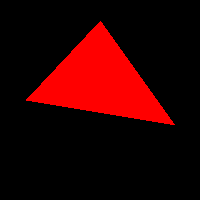

In [29]:
#判断是否在三角形内
def in_triangle(t, point):
    v0 = Vec2(t.v1[0] - t.v0[0], t.v1[1] - t.v0[1]).rotate(90)
    v1 = Vec2(t.v2[0] - t.v1[0], t.v2[1] - t.v1[1]).rotate(90)
    v2 = Vec2(t.v0[0] - t.v2[0], t.v0[1] - t.v2[1]).rotate(90)

    flag1 = v0.dot(point - Vec2(t.v0))
    flag2 = v1.dot(point - Vec2(t.v1))
    flag3 = v2.dot(point - Vec2(t.v2))

    if(flag1 > 0 and flag2 > 0 and flag3 > 0) or (flag1 < 0 and flag2 < 0 and flag3 < 0):
        return True
    else:
        return False

#通过点积来渲染三角形
def r_triange_dot(t, fb, color = (0, 0, 0)):
    max_x = max(t.v0[0], max(t.v1[0], t.v2[0]))
    max_y = max(t.v0[1], max(t.v1[1], t.v2[1]))

    min_x = min(t.v0[0], min(t.v1[0], t.v2[0]))
    min_y = min(t.v0[1], min(t.v1[1], t.v2[1]))

    for i in range(min_x, max_x):
        for j in range(min_y, max_y):
            if(in_triangle(t, Vec2(i, j))):
                fb.draw_point((i, j), color)

fb.clear()
r_triange_dot(t, fb, red)
fb.display()

### 重心坐标的算法
我们可以用三角形的顶点来作为坐标系，建立我们的重心坐标。因为我们表示的是二维的平面，所以我们需要通过将三个坐标和规定为一来减少一个自由度。

为什么叫重心坐标呢，是因为如果我们要表示的点作为重心，只需要在三角形的三个顶点上分配相应的权重就行了。

每个顶点的重心坐标值为对应的边，和所要表示的点形成的三角形的面积和总体面积的比值，全在三角形外的三角形面积为负数。相应的重心坐标就为负数，所以我们只要通过重心坐标的正负就能判断是否在三角形内了。

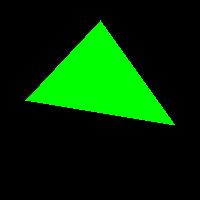

In [30]:
def barycentric(t, point):
    v0 = Vec2(t.v1) - Vec2(t.v0)
    v1 = Vec2(t.v2) - Vec2(t.v1)
    v2 = Vec2(t.v0) - Vec2(t.v2)

    # 向量的叉乘就是两个向量对应的平行四边形的面积
    # 因为是面积的比值，所以对应三角形面积的比值和平行四边形面积比值相同
    S = abs(v0.cross(v1))
    if(S == 0):
        return (-1, 1, 1)
    alpha = (Vec2(point) - Vec2(t.v0)).cross(v0) / S
    beta = (Vec2(point) - Vec2(t.v1)).cross(v1) / S
    gamma = (Vec2(point) - Vec2(t.v2)).cross(v2) / S

    #由于叉乘有方向性，如果是方向和我们预期的相反，那么我们的所有坐标值加起来就会等于-1
    #这时候我们就需要给他们全部取反
    if(alpha + beta + gamma + 1 < 1e-5):
        alpha = -alpha
        beta = -beta
        gamma = -gamma
    return (alpha, beta, gamma)

def r_triange_barycentric(t, fb, color):
    max_x = max(t.v0[0], max(t.v1[0], t.v2[0]))
    max_y = max(t.v0[1], max(t.v1[1], t.v2[1]))

    min_x = min(t.v0[0], min(t.v1[0], t.v2[0]))
    min_y = min(t.v0[1], min(t.v1[1], t.v2[1]))

    for i in range(min_x, max_x):
        for j in range(min_y, max_y):
            coord = barycentric(t, (i, j))
            if(coord[0] >= 0 and coord[1] >= 0 and coord[2] >= 0):
                fb.draw_point((i, j), color)

fb.clear()
r_triange_barycentric(t, fb, green)
fb.display()

# 平面渲染芭芭拉
现在我们知道了三角形怎么渲染了，然后我们就给我们上节课渲染的芭芭拉来上色吧。
我们给每个像素一个随机的颜色。

In [31]:
import model
import random
from math import floor
babala = model.Model("./obj/babala/babala.obj")


fb = buffer.FrameBuffer(1000, 1000)

for i in babala.face:
    v = babala.get_vertex(i)
    sv = []
    for i in range(3):
        x, y, _ = v[i]
        sv.append((floor((x / babala.scala + 1) * fb.width / 2), floor((-y / babala.scala + 1) * fb.height / 2)))
    t = Triangle(sv[0], sv[1], sv[2])
    r_triange_barycentric(t, fb, tuple((random.randint(0, 255) for i in range(3))))
fb.display()



'\nfor i in babala.face:\n    v = babala.get_vertex(i)\n    sv = []\n    for i in range(3):\n        x, y, _ = v[i]\n        sv.append((floor((x / babala.scala + 1) * fb.width / 2), floor((-y / babala.scala + 1) * fb.height / 2)))\n    t = Triangle(sv[0], sv[1], sv[2])\n    r_triange_barycentric(t, fb, tuple((random.randint(0, 255) for i in range(3))))\nfb.display()\n'

## 来点光吧！
我们这次使用漫反射光源，用射向z轴负方向的光源，然后利用三角形一个点的向量和光源的点击来确定光强。

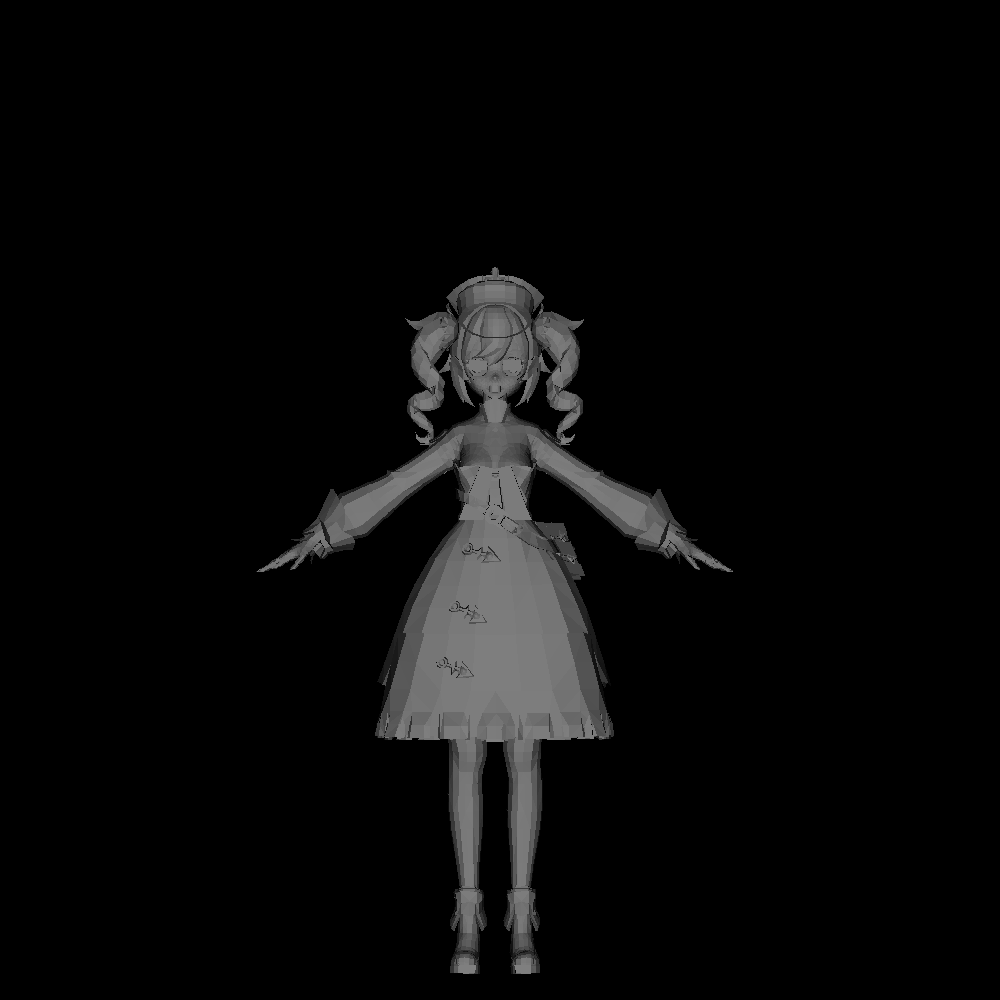

In [36]:
light = Vec3(0, 0, -0.5)
for i in babala.face:
    v = babala.get_vertex(i)
    sv = []
    for i in range(3):
        x, y, _ = v[i]
        sv.append((floor((x / babala.scala + 1) * fb.width / 2), floor((-y / babala.scala + 1) * fb.height / 2)))
    t = Triangle(sv[0], sv[1], sv[2])
    v = (Vec3(v[1]) - Vec3(v[0])).cross(Vec3(v[2]) - Vec3(v[0]))
    v.norm()
    color = light.dot(v)
    if(color > 0):
        r_triange_barycentric(t, fb, tuple(floor(color * 255) for i in range(3)))
fb.display()

芭芭拉冲压！